In [168]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv
/kaggle/input/nnpreds/neural3.csv


In [169]:
train_dta = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_dta = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission_dta = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

In [170]:
train_dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Datatype transformations basic feature engineering

In [171]:
train_dta.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2032,2172_01,Earth,False,G/347/S,PSO J318.5-22,23.0,False,0.0,774.0,0.0,0.0,0.0,Belly Barbes,True
7465,7986_01,Mars,False,F/1655/P,TRAPPIST-1e,21.0,False,838.0,45.0,455.0,0.0,0.0,Weet Pimne,False
496,0534_02,Europa,False,B/23/P,TRAPPIST-1e,49.0,False,3573.0,1308.0,316.0,641.0,25.0,Weia Parbage,False
2106,2257_02,Europa,True,B/66/P,55 Cancri e,22.0,False,0.0,0.0,0.0,0.0,0.0,Nasliak Diateous,True
4450,4728_02,Mars,True,F/889/S,NaN,49.0,False,NaN,0.0,0.0,0.0,0.0,Galowl Curle,True


In [172]:
train_dta.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [173]:
train_dta.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Text(0.5, 1.0, 'Target distribution')

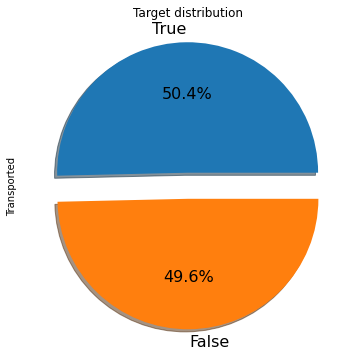

In [174]:
plt.figure(figsize=(6,6))
train_dta['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Text(0.5, 0, 'Age (years)')

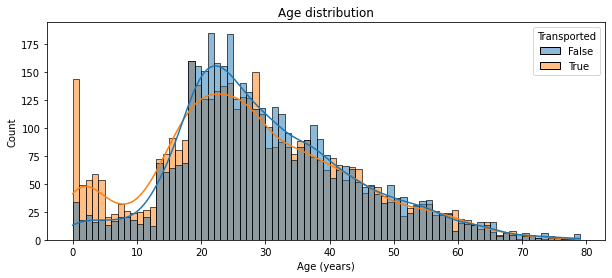

In [175]:
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train_dta, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

In [176]:
qual_ft=['PassengerId', 'Cabin' ,'Name']

# Preview of qualitative features
train_dta[qual_ft].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


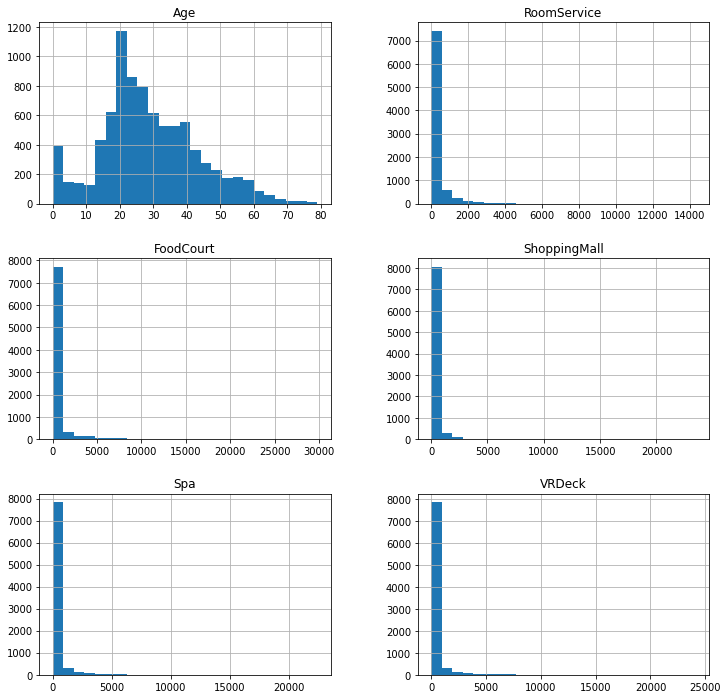

In [177]:
train_dta.hist(bins = 25, figsize = (12, 12))
plt.show()

Text(0, 0.5, 'Transported Probability by VIP')

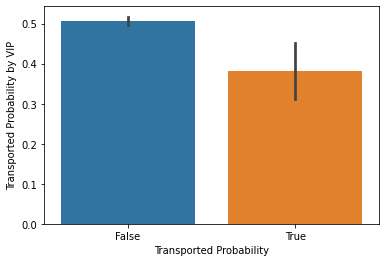

In [178]:
sns.barplot(x="VIP", y="Transported", data=train_dta)
plt.xlabel("Transported Probability")
plt.ylabel("Transported Probability by VIP")

Text(0, 0.5, 'Transported Probability by CryoSleep')

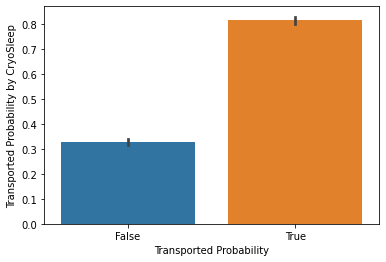

In [179]:
sns.barplot(x="CryoSleep", y="Transported", data=train_dta)
plt.xlabel("Transported Probability")
plt.ylabel("Transported Probability by CryoSleep")

Text(0.5, 1.0, 'Transported Probability by Home Planet')

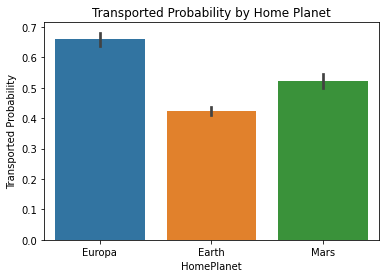

In [180]:
sns.barplot(x = 'HomePlanet', y ='Transported', data = train_dta)
plt.ylabel('Transported Probability')
plt.title('Transported Probability by Home Planet')

In [ ]:
numeric_data = [column for column in train_dta.select_dtypes(["int", "float"])]
categoric_data = [column for column in train_dta.select_dtypes(exclude = ["int", "float"])]
test_categoric_data = [column for column in test_dta.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    train_dta[col].fillna(train_dta[col].median(), inplace = True)
    test_dta[col].fillna(test_dta[col].median(), inplace = True)
    
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    train_dta[col].fillna(train_dta[col].value_counts().index[0], inplace = True)
for col in test_categoric_data:
    test_dta[col].fillna(test_dta[col].value_counts().index[0], inplace = True) 

In [181]:
train_dta['Transported'].replace(True, 1, inplace=True)

train_dta.Transported = train_dta.Transported.astype(int)

train_dta['VIP'].replace(False, 0, inplace=True)
train_dta['VIP'].replace(True, 1, inplace=True)
test_dta['VIP'].replace(False, 0, inplace=True)
test_dta['VIP'].replace(True, 1, inplace=True)

test_dta.VIP = test_dta.VIP.astype("Int8")
train_dta.VIP = train_dta.VIP.astype("Int8")

train_dta.CryoSleep.replace(False, 0, inplace=True)
test_dta.CryoSleep.replace(False, 0, inplace=True)

train_dta.CryoSleep.replace(True, 1, inplace=True)
test_dta.CryoSleep.replace(True, 1, inplace=True)

test_dta.CryoSleep = test_dta.CryoSleep.astype("Int8")
train_dta.CryoSleep = train_dta.CryoSleep.astype("Int8")

In [182]:
train_dta[['deck','num', 'side']] = train_dta['Cabin'].str.split('/', expand=True)
test_dta[['deck','num', 'side']] = test_dta['Cabin'].str.split('/', expand=True)

train_dta.drop('Cabin', axis=1, inplace=True)
test_dta.drop('Cabin', axis=1, inplace=True)

In [183]:
col_sum = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_dta['SumSpends'] = train_dta[col_sum].sum(axis=1)
test_dta['SumSpends'] = test_dta[col_sum].sum(axis=1)

train_dta['MaxSpends'] = train_dta[col_sum].max(axis=1)
test_dta['MaxSpends'] = test_dta[col_sum].max(axis=1)

In [184]:
train_dta['log_spend'] = np.log(train_dta.SumSpends + 1)
test_dta['log_spend'] = np.log(test_dta.SumSpends + 1)

In [185]:
null_col = train_dta.isnull().sum().sort_values(ascending=False)
null_col = list(null_col[null_col>1].index)

In [186]:
obj_col = [col for col in train_dta.columns if train_dta[col].dtype == 'object' or train_dta[col].dtype == 'category']

ord_c = OrdinalEncoder()

df_for_encode = pd.concat([train_dta, test_dta])

df_for_encode[obj_col] = df_for_encode[obj_col].astype('category')

df_for_encode[obj_col] = ord_c.fit_transform(df_for_encode[obj_col])

del train_dta, test_dta

train_dta = df_for_encode.iloc[:8693, :]
test_dta = df_for_encode.iloc[8693: , :]

del df_for_encode

test_dta.drop('Transported', inplace=True, axis=1)

In [187]:
col_tran = ColumnTransformer([("imp", SimpleImputer(strategy='mean'), null_col)])

train_dta[null_col] = col_tran.fit_transform(train_dta[null_col])
test_dta[null_col] = col_tran.transform(test_dta[null_col])

In [188]:
train_dta.drop('PassengerId', axis=1, inplace = True)
test_dta.drop('PassengerId', axis=1, inplace = True)

y_train_dta = train_dta['Transported']
X_train_dta = train_dta.drop('Transported', axis=1)
X_test_dta = test_dta

if X_train_dta.shape[1] == X_test_dta.shape[1]:
    print('Shapes are equal. Ready to train models.')
else:
    print('Error in preprocessing step.')

Shapes are equal. Ready to train models.


In [200]:
cv = StratifiedKFold(n_splits = 8, shuffle=True, random_state=42)
fold_accuracy = []
for tr_idx, val_idx in cv.split(X_train_dta, y_train_dta):
    X_tr, y_tr, X_val, y_val = X_train_dta.iloc[tr_idx], y_train_dta.iloc[tr_idx], X_train_dta.iloc[val_idx], y_train_dta.iloc[val_idx]
    model = CatBoostClassifier(eval_metric = 'Accuracy', verbose=0, rsm = 0.80, iterations = 1000)
    model.fit(X_tr, y_tr)
    pred_fold = model.predict(X_val)
    fold_accuracy.append(accuracy_score(pred_fold, y_val))

print(f'Accuracy = {np.mean(fold_accuracy)}')
print(f'fold accuracy: {fold_accuracy}')

Accuracy = 0.816632528069043
fold accuracy: [0.8252069917203312, 0.8344066237350506, 0.8187672493100276, 0.8104875804967802, 0.8077276908923643, 0.8038674033149171, 0.8342541436464088, 0.7983425414364641]


In [201]:
pred = pd.DataFrame({})
for i in range(20):
    catb = CatBoostClassifier(eval_metric = 'Accuracy', verbose=0, rsm = 0.82, iterations = 10000, random_seed = i*7 + 4)
    catb.fit(X_train_dta, y_train_dta)
    print(f"Train accuracy: {accuracy_score(y_train_dta, catb.predict(X_train_dta))}")
    pred[f"CATB_{i}"] = catb.predict_proba(X_test_dta)[:, 1]

Train accuracy: 0.8989991947544
Train accuracy: 0.8993443000115036
Train accuracy: 0.8986540894972966
Train accuracy: 0.898078914068791
Train accuracy: 0.8986540894972966
Train accuracy: 0.8992292649258024
Train accuracy: 0.8981939491544921
Train accuracy: 0.898078914068791
Train accuracy: 0.8989991947544
Train accuracy: 0.8995743701829058
Train accuracy: 0.8989991947544
Train accuracy: 0.8989991947544
Train accuracy: 0.8973887035545841
Train accuracy: 0.8993443000115036
Train accuracy: 0.8993443000115036
Train accuracy: 0.8987691245829978
Train accuracy: 0.8989991947544
Train accuracy: 0.899689405268607
Train accuracy: 0.8995743701829058
Train accuracy: 0.8979638789830898


In [202]:
from xgboost import XGBClassifier
fold_acc = []
for tr_idx, val_idx in cv.split(X_train_dta, y_train_dta):
    X_tr, y_tr, X_val, y_val = X_train_dta.iloc[tr_idx], y_train_dta.iloc[tr_idx], X_train_dta.iloc[val_idx], y_train_dta.iloc[val_idx]
    model = XGBClassifier(max_depth = 4, subsample = 0.75, n_estimators = 550, learning_rate = 0.03, min_child_weight = 0.9, random_state = 1)
    model.fit(X_tr, y_tr)
    pred_fold = model.predict(X_val)
    fold_acc.append(accuracy_score(pred_fold, y_val))

print(f'Accuracy = {np.mean(fold_acc)}')
print(f'fold accuracy: {fold_acc}')

Accuracy = 0.8097323805022016
fold accuracy: [0.8104875804967802, 0.8132474701011959, 0.8150873965041399, 0.796688132474701, 0.8095676172953082, 0.8075506445672191, 0.8305709023941068, 0.7946593001841621]


In [203]:
for i in range(20):
    xgb = XGBClassifier(max_depth = 4, subsample = 0.75, n_estimators = 550, learning_rate = 0.03, min_child_weight = 0.9, random_state = i*2 + 1)
    xgb.fit(X_train_dta, y_train_dta)
    print(f"Train Accuracy: {accuracy_score(y_train_dta, xgb.predict(X_train_dta))}")
    pred[f"XGB_{i}"] = xgb.predict_proba(X_test_dta)[:, 1]

Train Accuracy: 0.8564362130449787
Train Accuracy: 0.8547106867594616
Train Accuracy: 0.8549407569308639
Train Accuracy: 0.853330265731048
Train Accuracy: 0.8554008972736684
Train Accuracy: 0.8549407569308639
Train Accuracy: 0.8556309674450707
Train Accuracy: 0.8551708271022662
Train Accuracy: 0.8556309674450707
Train Accuracy: 0.8544806165880594
Train Accuracy: 0.8552858621879673
Train Accuracy: 0.8547106867594616
Train Accuracy: 0.8551708271022662
Train Accuracy: 0.8547106867594616
Train Accuracy: 0.8542505464166571
Train Accuracy: 0.855861037616473
Train Accuracy: 0.8551708271022662
Train Accuracy: 0.855861037616473
Train Accuracy: 0.8542505464166571
Train Accuracy: 0.8534453008167491


In [206]:
from lightgbm import LGBMClassifier
fold_acc = []
for tr_idx, val_idx in cv.split(X_train_dta, y_train_dta):
    X_tr, y_tr, X_val, y_val = X_train_dta.iloc[tr_idx], y_train_dta.iloc[tr_idx], X_train_dta.iloc[val_idx], y_train_dta.iloc[val_idx]
    model = LGBMClassifier(min_child_weight=0.8, random_state=1, n_estimators=600, learning_rate = 0.01, subsample=0.7, subsample_freq=1, colsample_bytree = 0.85)
    model.fit(X_tr, y_tr)
    pred_fold = model.predict(X_val)
    fold_acc.append(accuracy_score(pred_fold, y_val))

print(f'Accuracy = {np.mean(fold_acc)}')
print(f'fold accuracy: {fold_acc}')

Accuracy = 0.8103066162804685
fold accuracy: [0.8178472861085556, 0.8187672493100276, 0.8114075436982521, 0.8012879484820608, 0.8068077276908924, 0.8093922651933702, 0.8268876611418048, 0.7900552486187845]


In [207]:
for i in range(20):
    lgb = LGBMClassifier(min_child_weight=0.8, random_state=i*5 + 6, n_estimators=600, learning_rate = 0.01, subsample=0.7, subsample_freq=1, colsample_bytree = 0.85)
    lgb.fit(X_train_dta, y_train_dta)
    print(f"Train Accuracy: {accuracy_score(y_train_dta, lgb.predict(X_train_dta))}")
    pred[f"LGB_{i}"] = lgb.predict_proba(X_test_dta)[:, 1]

Train Accuracy: 0.8620729322443346
Train Accuracy: 0.8632232831013459
Train Accuracy: 0.8631082480156448
Train Accuracy: 0.8634533532727482
Train Accuracy: 0.8631082480156448
Train Accuracy: 0.864143563786955
Train Accuracy: 0.8631082480156448
Train Accuracy: 0.8603474059588174
Train Accuracy: 0.8637984585298516
Train Accuracy: 0.8631082480156448
Train Accuracy: 0.8640285287012539
Train Accuracy: 0.8633383181870471
Train Accuracy: 0.8613827217301276
Train Accuracy: 0.860807546301622
Train Accuracy: 0.862418037501438
Train Accuracy: 0.8631082480156448
Train Accuracy: 0.8629932129299437
Train Accuracy: 0.8647187392154607
Train Accuracy: 0.8609225813873231
Train Accuracy: 0.8628781778442425


In [213]:
nn_pred_data = pd.read_csv('/kaggle/input/nnpreds/neural3.csv')

In [214]:
pred

,CATB_0,CATB_1,CATB_2,CATB_3,CATB_4,CATB_5,CATB_6,CATB_7,CATB_8,CATB_9,...,LGB_10,LGB_11,LGB_12,LGB_13,LGB_14,LGB_15,LGB_16,LGB_17,LGB_18,LGB_19
0,0.509965,0.500890,0.506474,0.503761,0.504234,0.502473,0.506196,0.505639,0.505095,0.508936,...,0.485719,0.502300,0.510607,0.475925,0.492649,0.484380,0.481883,0.490807,0.507809,0.500662
1,0.008322,0.007517,0.007843,0.008287,0.008074,0.007756,0.009215,0.007027,0.008834,0.007583,...,0.026289,0.026907,0.028830,0.025384,0.028460,0.026813,0.028620,0.025228,0.028083,0.027443
2,0.987125,0.988011,0.986781,0.986239,0.986230,0.988192,0.987349,0.985049,0.988627,0.986452,...,0.985213,0.987804,0.986969,0.982287,0.987347,0.985280,0.985656,0.987048,0.984264,0.985994
3,0.977937,0.978935,0.978725,0.980113,0.980965,0.978509,0.981666,0.977410,0.977643,0.979498,...,0.979653,0.978668,0.979535,0.976454,0.982304,0.978526,0.978781,0.981134,0.974041,0.978133
4,0.421432,0.430174,0.436652,0.429161,0.437972,0.424950,0.422893,0.432856,0.437675,0.431267,...,0.574926,0.556869,0.548313,0.572894,0.549889,0.548625,0.523697,0.534965,0.546620,0.535906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.592771,0.588565,0.596112,0.590282,0.595527,0.594635,0.590190,0.594250,0.596573,0.589507,...,0.565678,0.569290,0.583187,0.569125,0.556746,0.565635,0.569339,0.569168,0.578599,0.567998
4273,0.325703,0.335672,0.349765,0.339904,0.338157,0.338610,0.328187,0.345598,0.360462,0.334116,...,0.308187,0.340238,0.372302,0.342679,0.335432,0.300543,0.383278,0.347591,0.371023,0.341829
4274,0.925534,0.927155,0.925379,0.924343,0.922218,0.928414,0.926134,0.928485,0.920892,0.926469,...,0.952269,0.951177,0.946591,0.945393,0.941158,0.948696,0.945549,0.951559,0.946642,0.951581
4275,0.833678,0.826923,0.827209,0.829533,0.844219,0.845634,0.838764,0.834590,0.826732,0.828289,...,0.771703,0.764888,0.768742,0.755809,0.754878,0.739151,0.765453,0.786189,0.721791,0.789766


In [215]:
cat_preds = pred.iloc[:, :10].mean(axis=1)
xgb_preds = pred.iloc[:,10:20].mean(axis=1)
lgb_preds = pred.iloc[:, 20:].mean(axis=1)
nn_preds = nn_pred_data.mean(axis=1)

XGB, LGBM, and CatBoost models are very similar by their nature. For diversification, we used a higher weight for NN model.

In [211]:
final_preds = cat_preds * (1/6) + nn_preds * (1/2) + lgb_preds * (1/6) + xgb_preds * (1/6)

In [212]:
sample = pd.read_csv(f'/kaggle/input/spaceship-titanic/sample_submission.csv')

sample.Transported = final_preds > 0.5
sample.to_csv("final output 2.csv", index = False)